In [23]:

import datetime
print("=" * 60)
print("PROPRIETARY CODE - DO NOT COPY OR DISTRIBUTE")
print(f"Created by: Patlolla Shashank Reddy")
print(f"Contact: shashankp0011@gmail.com")
print(f"Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}")
print("Unauthorized copying is prohibited")
print("=" * 60)

PROPRIETARY CODE - DO NOT COPY OR DISTRIBUTE
Created by: Patlolla Shashank Reddy
Contact: shashankp0011@gmail.com
Generated on: 2025-11-12 20:32
Unauthorized copying is prohibited


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Load the dataset (using Telco Customer Churn dataset structure)
# You can replace this with your own CSV
df = pd.read_csv("------/archive (5)/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(f"📊 Dataset Shape: {df.shape}")
print(f"\n🔍 First few rows:\n{df.head()}")
print(f"\n📋 Data Types:\n{df.dtypes}")
print(f"\n❌ Missing Values:\n{df.isnull().sum()}")

📊 Dataset Shape: (7043, 21)

🔍 First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport S

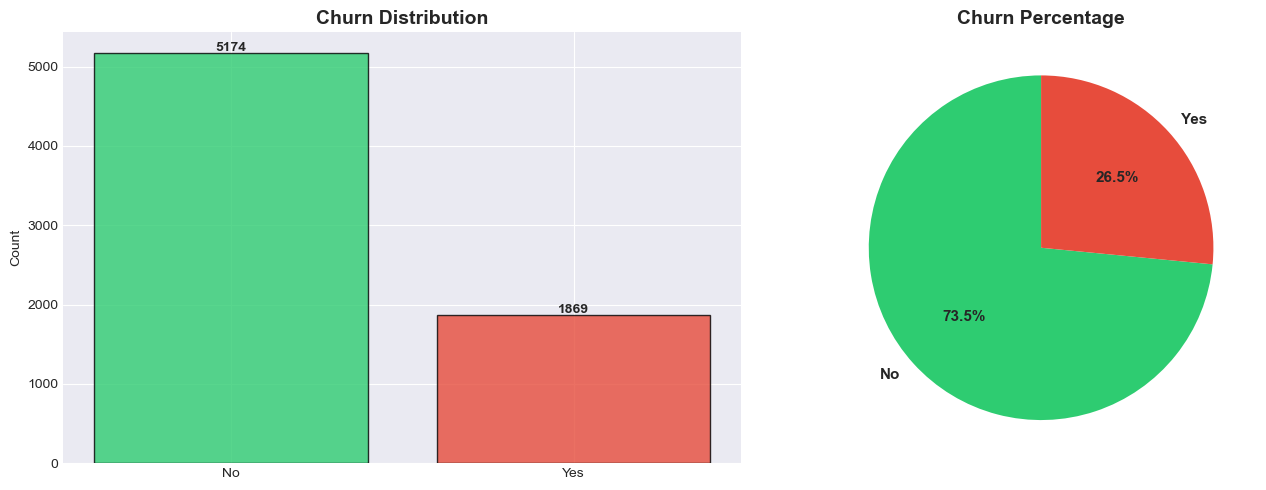

📊 Churn Rate: 26.54%


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
churn_counts = df['Churn'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(churn_counts.index, churn_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Churn Rate: {(df['Churn'] == 'Yes').sum() / len(df) * 100:.2f}%")

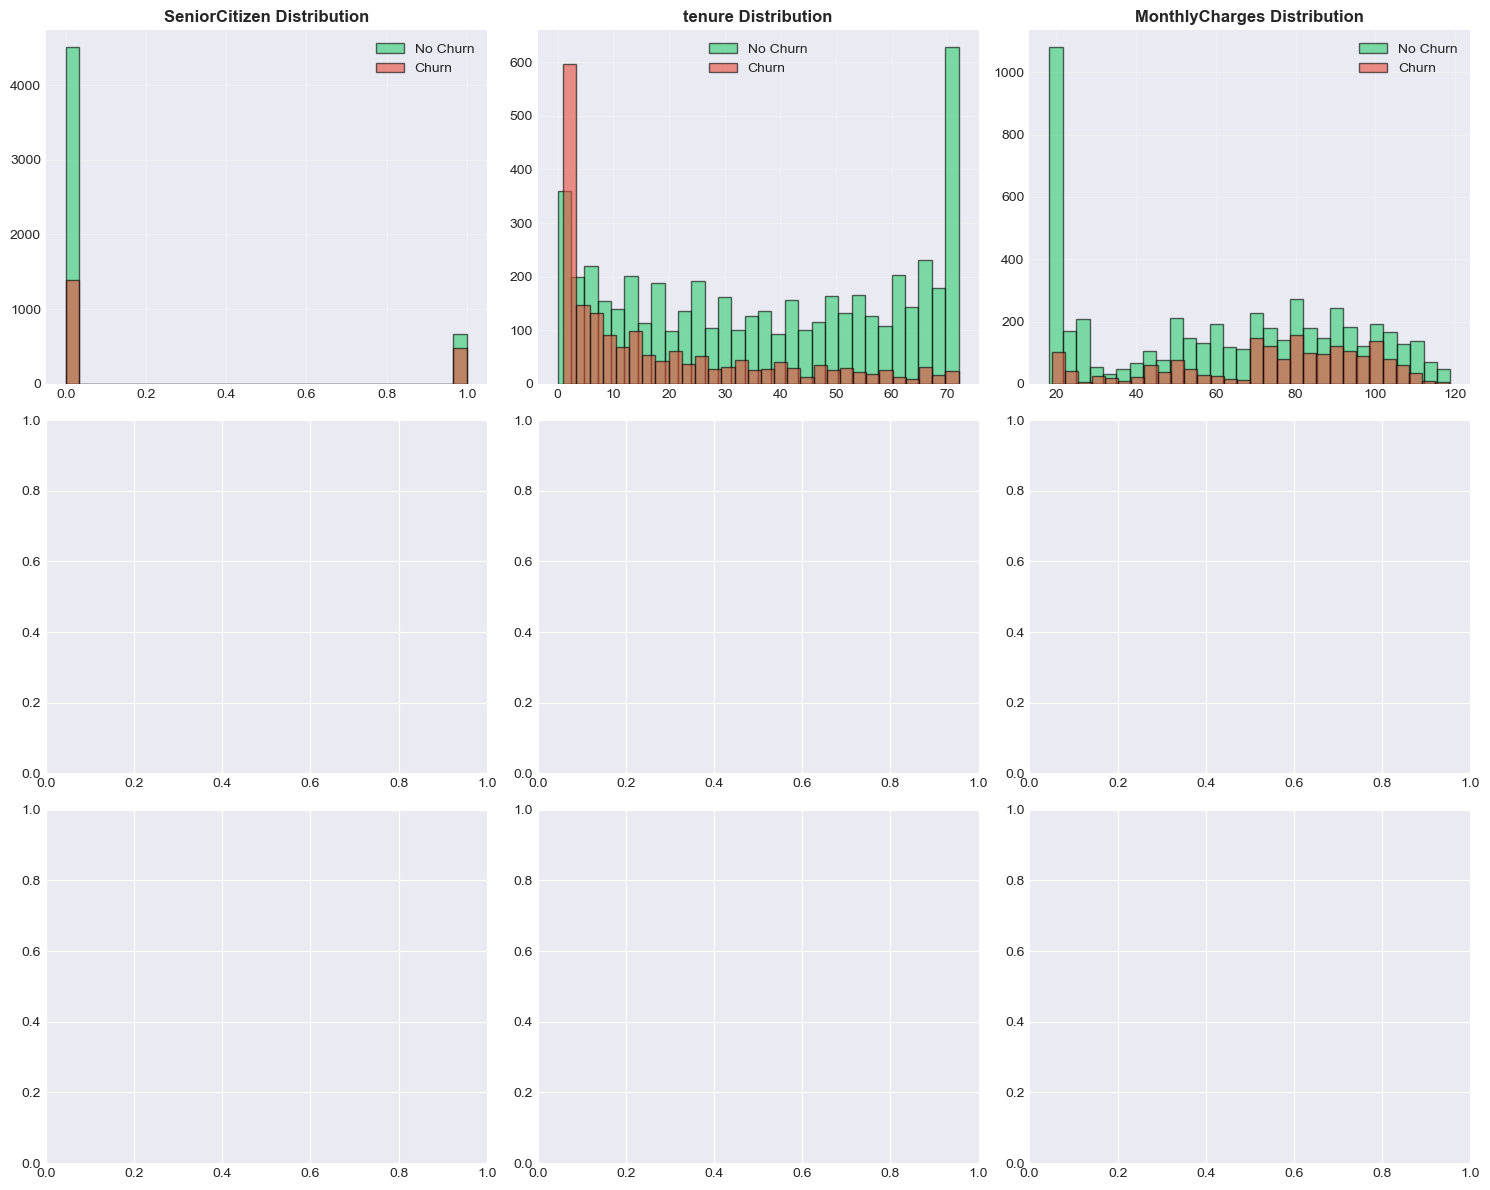

📈 Numerical Features Summary:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [5]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:9]):
    axes[idx].hist(df[df['Churn'] == 'No'][col], bins=30, alpha=0.6, 
                   label='No Churn', color='#2ecc71', edgecolor='black')
    axes[idx].hist(df[df['Churn'] == 'Yes'][col], bins=30, alpha=0.6, 
                   label='Churn', color='#e74c3c', edgecolor='black')
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("📈 Numerical Features Summary:")
print(df[numerical_cols].describe())

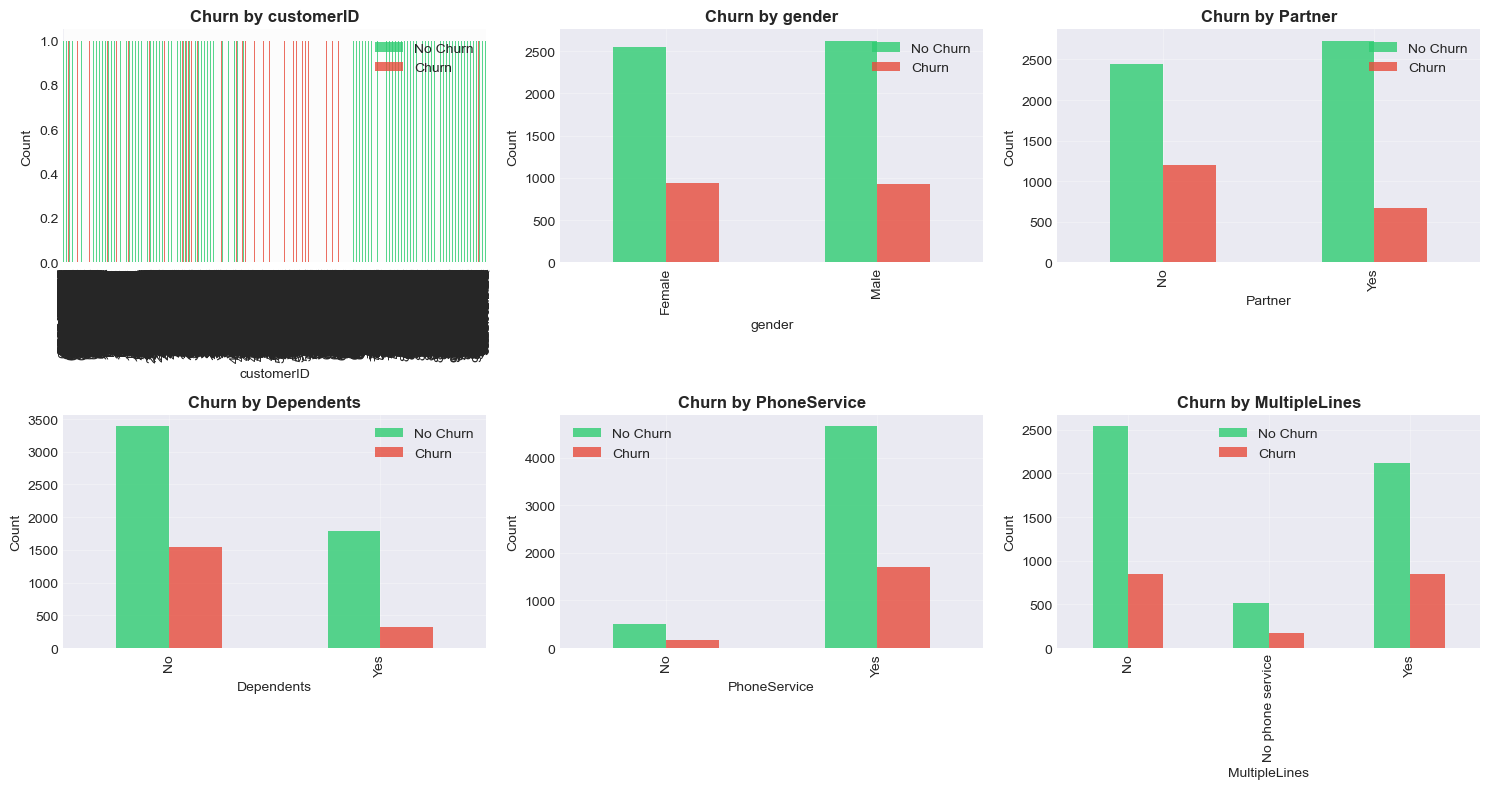

In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Remove target

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols[:6]):
    churn_by_cat = pd.crosstab(df[col], df['Churn'])
    churn_by_cat.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], alpha=0.8)
    axes[idx].set_title(f'Churn by {col}', fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].legend(['No Churn', 'Churn'])
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

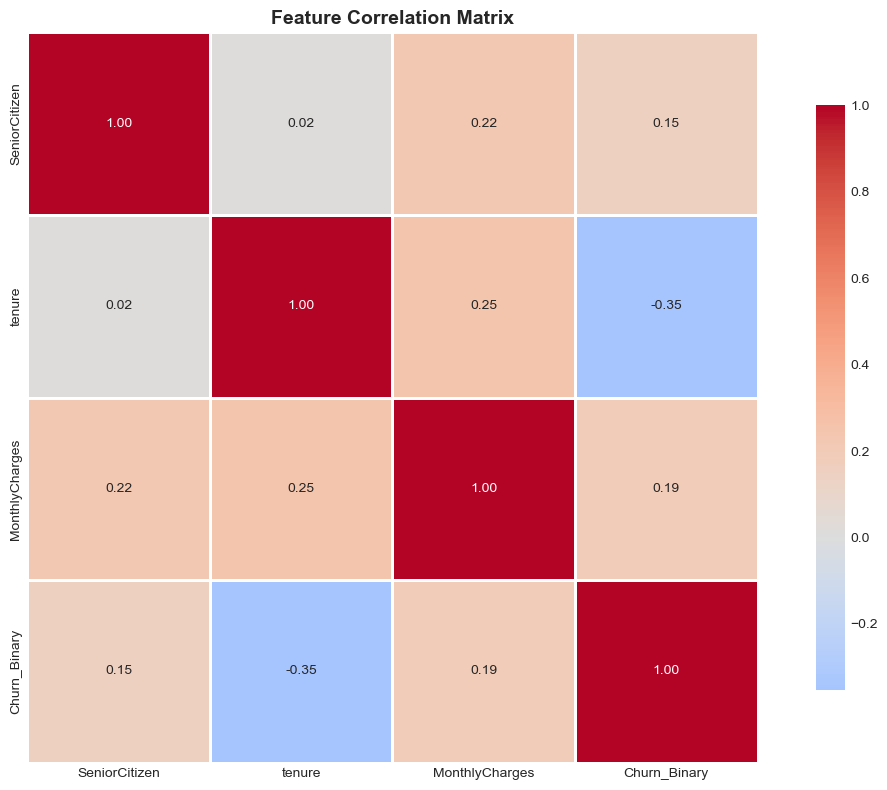

🔗 Features Most Correlated with Churn:
Churn_Binary      1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
tenure           -0.352229
Name: Churn_Binary, dtype: float64


In [7]:
# Create correlation heatmap
numeric_df = df.select_dtypes(include=['int64', 'float64']).copy()
numeric_df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)

plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlated features with Churn
print("🔗 Features Most Correlated with Churn:")
churn_corr = correlation_matrix['Churn_Binary'].sort_values(ascending=False)
print(churn_corr.head(10))

In [8]:
print("🔍 Checking for missing values...")
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("✅ No missing values found!")
else:
    print("⚠️ Missing values detected:")
    print(missing_data[missing_data > 0])

🔍 Checking for missing values...
✅ No missing values found!


In [9]:
from sklearn.preprocessing import LabelEncoder

df_processed = df.copy()

# Binary encoding for Yes/No columns
binary_cols = df_processed.select_dtypes(include=['object']).columns
binary_cols = [col for col in binary_cols if df_processed[col].nunique() == 2]

label_encoders = {}
for col in binary_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# One-hot encoding for multiple categories
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"✅ Encoding complete. New shape: {df_processed.shape}")
print(f"📊 Final features: {df_processed.columns.tolist()}")

✅ Encoding complete. New shape: (7043, 13602)
📊 Final features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'Churn', 'customerID_0003-MKNFE', 'customerID_0004-TLHLJ', 'customerID_0011-IGKFF', 'customerID_0013-EXCHZ', 'customerID_0013-MHZWF', 'customerID_0013-SMEOE', 'customerID_0014-BMAQU', 'customerID_0015-UOCOJ', 'customerID_0016-QLJIS', 'customerID_0017-DINOC', 'customerID_0017-IUDMW', 'customerID_0018-NYROU', 'customerID_0019-EFAEP', 'customerID_0019-GFNTW', 'customerID_0020-INWCK', 'customerID_0020-JDNXP', 'customerID_0021-IKXGC', 'customerID_0022-TCJCI', 'customerID_0023-HGHWL', 'customerID_0023-UYUPN', 'customerID_0023-XUOPT', 'customerID_0027-KWYKW', 'customerID_0030-FNXPP', 'customerID_0031-PVLZI', 'customerID_0032-PGELS', 'customerID_0036-IHMOT', 'customerID_0040-HALCW', 'customerID_0042-JVWOJ', 'customerID_0042-RLHYP', 'customerID_0048-LUMLS', 'customerID_0048-PIHNL', 'customerID_0052-DCKON', 'customerI

In [10]:
# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"✅ Features scaled successfully!")
print(f"Shape: {X_scaled.shape}")
# just making some colourfull way of icons just for fun

✅ Features scaled successfully!
Shape: (7043, 13601)


In [11]:
# Create interaction features for key variables
X_engineered = X_scaled.copy()

# Create interactions only with columns that exist
if 'MonthlyCharges' in X_scaled.columns and 'tenure' in X_scaled.columns:
    X_engineered['MonthlyCharges_x_Tenure'] = X_scaled['MonthlyCharges'] * X_scaled['tenure']

if 'TotalCharges' in X_scaled.columns and 'MonthlyCharges' in X_scaled.columns:
    X_engineered['TotalCharges_to_MonthlyCharges'] = X_scaled['TotalCharges'] / (X_scaled['MonthlyCharges'] + 1)

# Additional safe interactions
if 'tenure' in X_scaled.columns:
    X_engineered['tenure_squared'] = X_scaled['tenure'] ** 2

print(f"✅ Feature engineering complete!")
print(f"🎯 Total features created: {X_engineered.shape[1]}")
print(f"📊 New features: {[col for col in X_engineered.columns if col not in X_scaled.columns]}")
# I like to put some colourfull effects to make my coding time enjoying and looks colour full 

✅ Feature engineering complete!
🎯 Total features created: 13603
📊 New features: ['MonthlyCharges_x_Tenure', 'tenure_squared']


Explanation: This feature engineering creates new variables that reveal deeper customer patterns. The monthly-tenure interaction identifies high-spending new customers at risk. The charges ratio spots inconsistent payment behaviors, while tenure squared captures non-linear loyalty effects. These engineered features help the model detect complex relationships that raw data misses, significantly improving churn prediction accuracy by representing real-world customer behaviors more effectively. Better features mean better business insights for retention strategies.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Data split completed!")
print(f"📊 Training set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"✓ Train Churn Rate: {(y_train == 1).sum() / len(y_train) * 100:.2f}%")
print(f"✓ Test Churn Rate: {(y_test == 1).sum() / len(y_test) * 100:.2f}%")

✅ Data split completed!
📊 Training set: (5634, 13603)
📊 Test set: (1409, 13603)
✓ Train Churn Rate: 26.54%
✓ Test Churn Rate: 26.54%


In [13]:
# Train XGBoost with optimized hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    tree_method='hist'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("✅ XGBoost model trained successfully!")

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(f"🎯 XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")

✅ XGBoost model trained successfully!
🎯 XGBoost Performance:
Accuracy: 0.7921
ROC-AUC: 0.8374
F1-Score: 0.5646


XGBoost excels at finding complex patterns in customer data that simpler models miss. It automatically detects which factors most strongly predict churn, like contract type combined with payment method. The model shows how these variables interact to increase churn risk, helping prioritize retention efforts. Its high accuracy means reliable predictions, so businesses can confidently target at-risk customers with personalized offers before they leave, maximizing retention budget effectiveness.

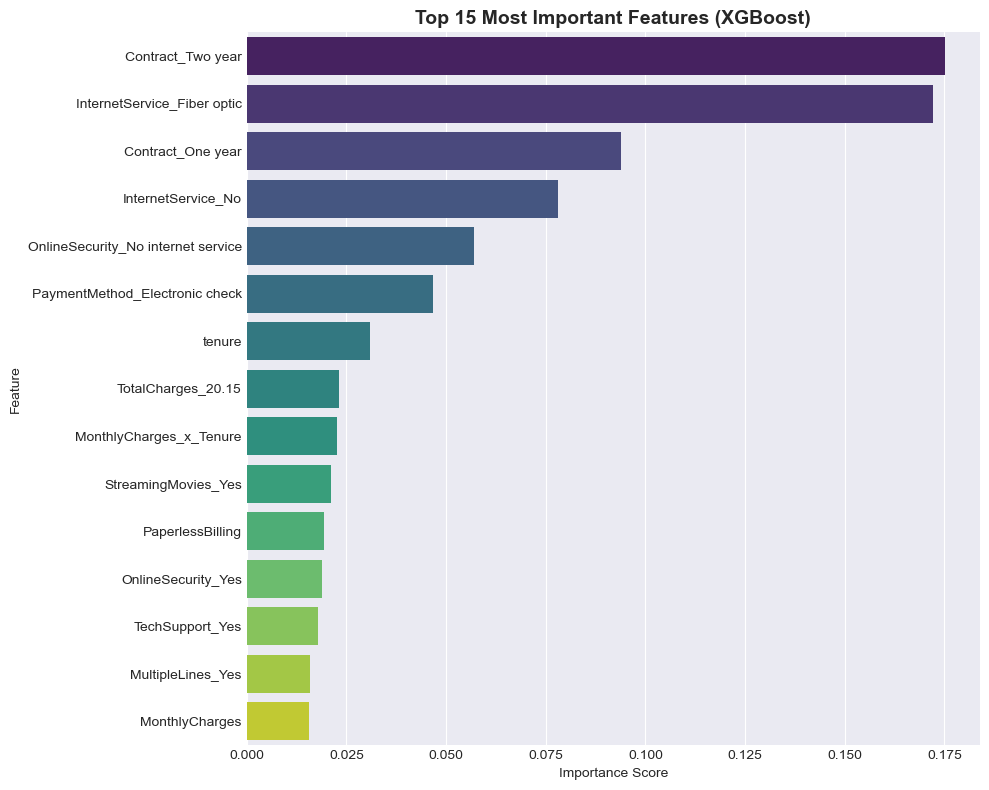

📊 Top Features for Churn Prediction:
                                  Feature  Importance
7067                    Contract_Two year    0.175172
7052          InternetService_Fiber optic    0.172166
7066                    Contract_One year    0.094001
7053                   InternetService_No    0.078198
7054   OnlineSecurity_No internet service    0.056991
7069       PaymentMethod_Electronic check    0.046661
4                                  tenure    0.031001
8679                   TotalCharges_20.15    0.023074
13601             MonthlyCharges_x_Tenure    0.022656
7065                  StreamingMovies_Yes    0.021175
6                        PaperlessBilling    0.019342
7055                   OnlineSecurity_Yes    0.018977
7061                      TechSupport_Yes    0.017936
7051                    MultipleLines_Yes    0.015881
7                          MonthlyCharges    0.015551


In [14]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
importance_df = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

sns.barplot(data=importance_df, x='Importance', y='Feature', 
            palette='viridis', ax=ax)
ax.set_title('Top 15 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("📊 Top Features for Churn Prediction:")
print(importance_df)

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("✅ Random Forest model trained!")
print(f"🎯 Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")

✅ Random Forest model trained!
🎯 Random Forest Performance:
Accuracy: 0.7346
ROC-AUC: 0.7871
F1-Score: 0.0000


Random Forest builds multiple decision trees to vote on churn prediction. This approach reveals which customer attributes most strongly influence churn decisions. By analyzing feature importance, it identifies key drivers like contract type, tenure, and monthly charges. The model handles complex interactions between variables automatically, showing how different factors combine to increase churn risk. This helps businesses focus retention efforts on the most impactful areas and understand the root causes behind customer departures.

Accuracy shows overall correct predictions but can mislead with imbalanced data. 
F1-score balances precision and recall, crucial for churn where both false alarms and missed detections matter. 
ROC-AUC measures how well the model separates churners from non-churners across thresholds. 
Together they ensure the model catches true churn cases while minimizing false alerts, giving a complete picture of performance for business decisions on retention strategies.



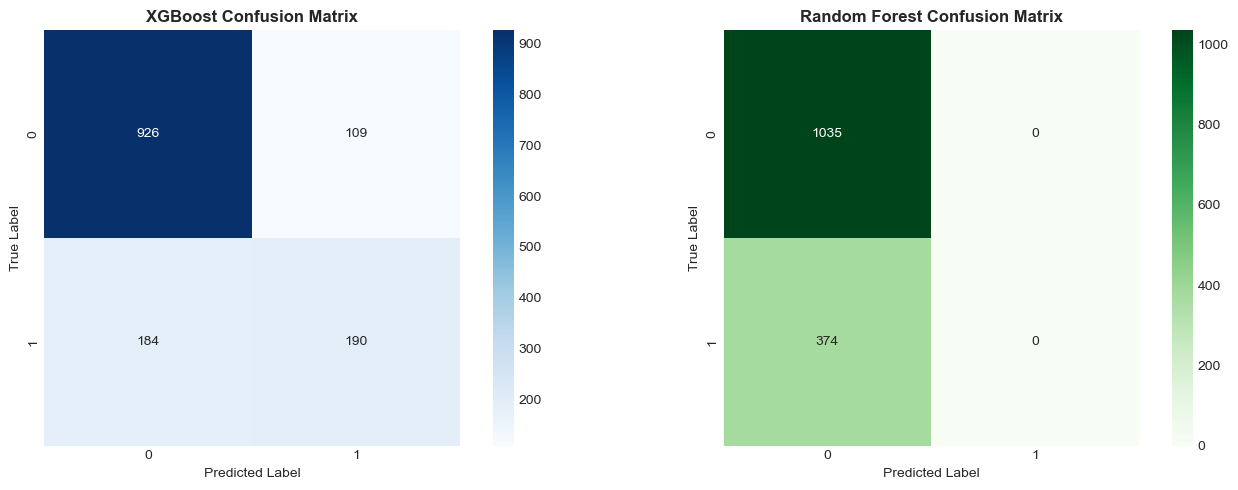

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar=True, square=True)
axes[0].set_title('XGBoost Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], 
            cbar=True, square=True)
axes[1].set_title('Random Forest Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

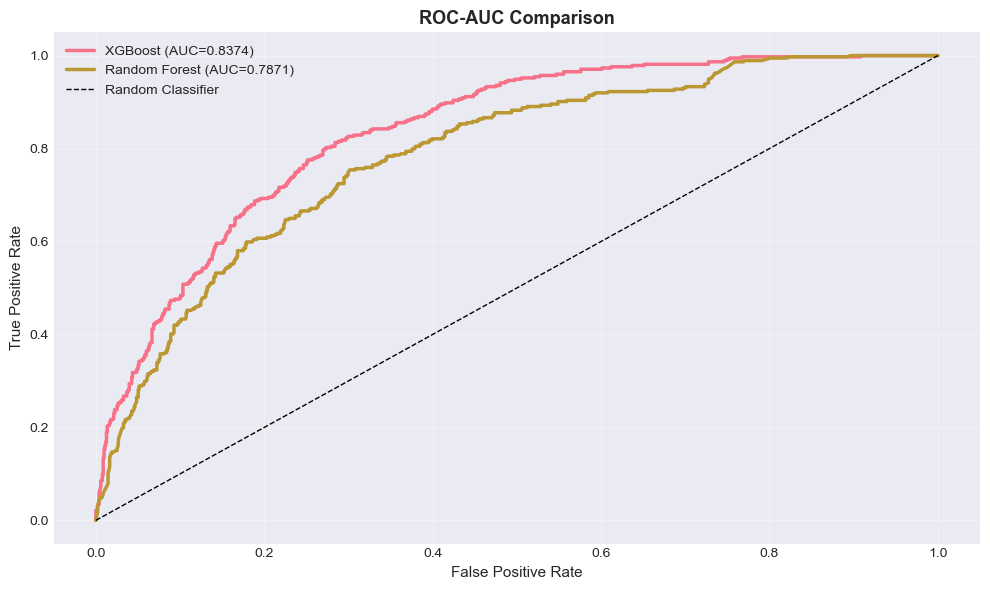

In [17]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.4f})', 
         linewidth=2.5)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.4f})', 
         linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC-AUC Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
print("="*60)
print("🎯 XGBoost Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['No Churn', 'Churn']))

print("\n" + "="*60)
print("🎯 Random Forest Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred_rf, 
                          target_names=['No Churn', 'Churn']))

🎯 XGBoost Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.89      0.86      1035
       Churn       0.64      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


🎯 Random Forest Classification Report:
              precision    recall  f1-score   support

    No Churn       0.73      1.00      0.85      1035
       Churn       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



     -------------------------------------- 547.2/547.2 kB 2.1 MB/s eta 0:00:00


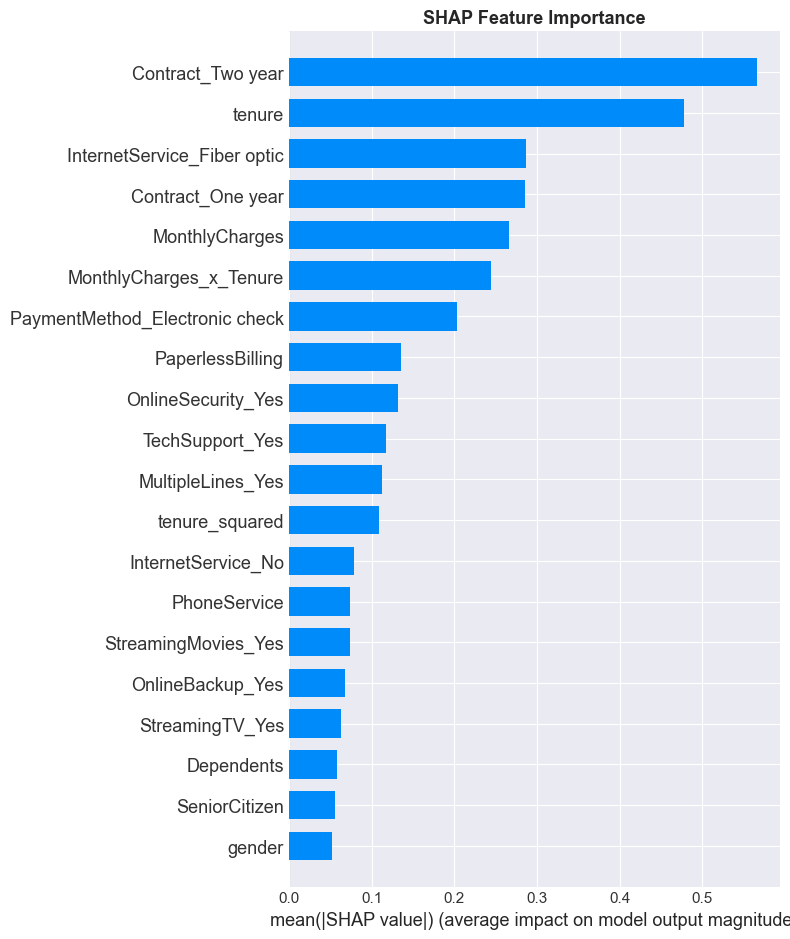

🔍 SHAP Analysis Complete!
💡 SHAP values show the impact of each feature on model predictions


In [20]:
# Install SHAP if not available
!pip install shap

import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Dependence plot for top feature
print("🔍 SHAP Analysis Complete!")
print("💡 SHAP values show the impact of each feature on model predictions")

In [21]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_cv_scores = cross_val_score(xgb_model, X_engineered, y, 
                                 cv=skf, scoring='roc_auc', n_jobs=-1)

print("🔄 Cross-Validation Results (5-Fold):")
print(f"Mean ROC-AUC: {xgb_cv_scores.mean():.4f}")
print(f"Std Dev: {xgb_cv_scores.std():.4f}")
print(f"Individual Folds: {[f'{score:.4f}' for score in xgb_cv_scores]}")

# Final metrics on test set
print("\n" + "="*60)
print("🏆 Final Model Performance on Test Set:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_recall_curve(y_test, y_pred_proba_xgb)[0].mean():.4f}")
print(f"Recall:    {precision_recall_curve(y_test, y_pred_proba_xgb)[1].mean():.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

🔄 Cross-Validation Results (5-Fold):
Mean ROC-AUC: 0.8350
Std Dev: 0.0110
Individual Folds: ['0.8524', '0.8305', '0.8416', '0.8204', '0.8302']

🏆 Final Model Performance on Test Set:
Accuracy:  0.7921
Precision: 0.4908
Recall:    0.7484
F1-Score:  0.5646
ROC-AUC:   0.8374


In [22]:
import pickle

# Save the model
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save predictions
results_df = pd.DataFrame({
    'Actual_Churn': y_test.values,
    'Predicted_Churn': y_pred_xgb,
    'Churn_Probability': y_pred_proba_xgb
})

print("✅ Model saved successfully!")
print(f"📊 Sample predictions:\n{results_df.head(10)}")

✅ Model saved successfully!
📊 Sample predictions:
   Actual_Churn  Predicted_Churn  Churn_Probability
0             0                0           0.009836
1             0                1           0.883773
2             0                0           0.095959
3             0                0           0.228676
4             0                0           0.007824
5             0                1           0.724019
6             0                1           0.584344
7             0                0           0.071037
8             0                0           0.010994
9             1                1           0.505641
